In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift,ifftshift,fft,ifft
plt.rcParams.update({'font.size': 16})
from copy import copy

from matplotlib.axes import Subplot as _Subplot
from matplotlib.gridspec import SubplotSpec as _SubplotSpec
if hasattr(_SubplotSpec,'is_first_col'):
    def _fun(self):
        return self.get_subplotspec().is_first_col()
    _Subplot.is_first_col=_fun
    def _fun(self):
        return self.get_subplotspec().is_first_row()
    _Subplot.is_first_row=_fun
    def _fun(self):
        return self.get_subplotspec().is_last_col()
    _Subplot.is_last_col=_fun
    def _fun(self):
        return self.get_subplotspec().is_last_row()
    _Subplot.is_last_row=_fun

In [2]:
%matplotlib notebook

# Spectrum and Parameters

In [3]:
SW=200
TD=150
SI=2048
SF=150
O=100


SWH=SF*SW
dt=1/SWH

### Amplitudes, shifts, linewidths

In [4]:
A,delta1,lw1,delta2,lw2=[[] for _ in range(5)]
with open('peaks.txt','r') as f:
    for line in f:
        i,d1,l1,d2,l2=[float(x) for x in line.strip().split('\t')]
        A.append(i)
        delta1.append(d1)
        lw1.append(l1)
        delta2.append(d2)
        lw2.append(l2)
A,delta1,lw1,delta2,lw2=[np.array(x) for x in [A,delta1,lw1,delta2,lw2]]
A[np.argmax(A)]/=5

i=np.logical_and(delta2>53,delta2<65)

A,delta1,lw1=[np.atleast_2d(x[i]).T for x in [A,delta1,lw1]]

In [5]:
np.median(1/np.pi/lw1)

0.3784897576501673

### Calculate Spectrum

In [6]:
t=np.arange(TD)*dt
I=(A*np.exp(np.pi*SF*(1j*2*(delta1-O)-lw1)*np.atleast_2d(t))).sum(0)
I+=np.random.randn(*I.shape)*np.exp(1j*2*np.pi*np.random.rand(*I.shape))*A.max()/10

I0=copy(I)
I0[0]/=2
apod=np.cos(np.arange(TD)/TD*np.pi/2)**2
I0*=apod

S=fftshift(fft(I0,SI))
f=1/(2*dt)*np.linspace(-1,1,SI)
f-=np.diff(f[:2])/2

<IPython.core.display.Javascript object>


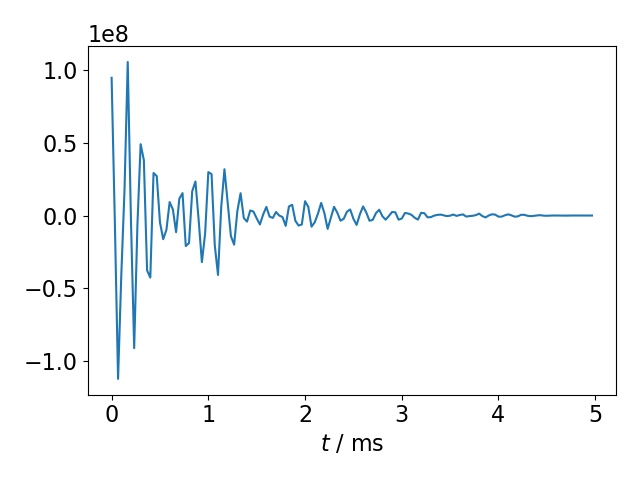

In [7]:
fig,ax=plt.subplots()
ax.plot(t*1e3,I0.real)
ax.set_xlabel(r'$t$ / ms')
fig.tight_layout()

<IPython.core.display.Javascript object>


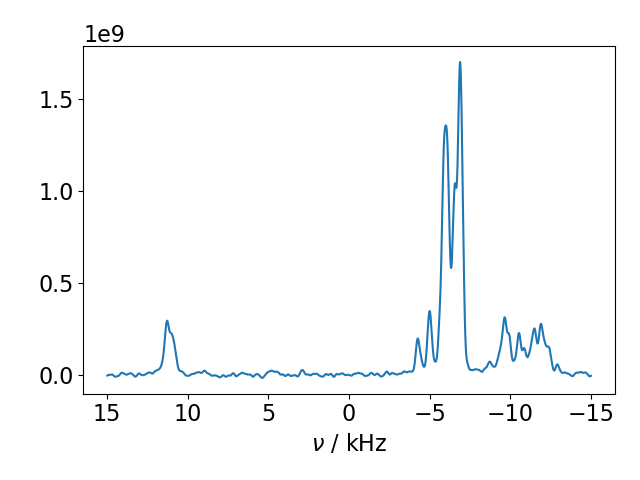

In [8]:
fig,ax=plt.subplots()
ax.plot(f/1e3,S.real)
ax.set_xlabel(r'$\nu$ / kHz')
ax.invert_xaxis()
fig.tight_layout()

# Sparse Sampling Schedule
Produces a number of sampling schedules:

* uniform: Equal step size between points (not actually NUS, and also not a good idea ;-) )
* beginning: All time points at the beginning of the spectrum
* random : Points are randomly placed (first and last point are always included)
* log : Points are log-spaced
* EMS : Random placement with exponential weighting of probability
* Poisson Gap : Poisson Gap sampling without sinusoidal weighting
* Sin Poisson Gap : Poisson Gap with sinusoidal weighting (this is usually what is meant by Poisson Gap)

In [69]:
from scipy.special import factorial
class Schedule():
    def __init__(self,TD:int,sparsity=.33):
        self.TD=TD
        self.sparsity=sparsity
        self.i=None
    
    def uniform(self):
        step=np.round(1/self.sparsity).astype(int)
        i=np.zeros(self.TD,dtype=bool)
        i[::step]=True
        self.i=i
        print(f'Sparsity: {self.i.sum()/self.i.size:.3f}')
        return i
    
    def beginning(self):
        i=np.zeros(self.TD,dtype=bool)
        n=np.round(self.sparsity*self.TD).astype(int)
        i[:n]=True
        self.i=i
        print(f'Sparsity: {self.i.sum()/self.i.size:.3f}')
        return i
    
    def random(self):
        sparsity=self.sparsity*(self.TD-2)/self.TD
        self.i=np.random.binomial(1,sparsity,self.TD).astype(bool)
        self.i[0]=True
        self.i[-1]=True
        print(f'Sparsity: {self.i.sum()/self.i.size:.3f}')
        return self.i
    
    def log(self):
        sc=1.7
        for k in range(5):
            i0=np.logspace(0,np.log10(self.TD),int(self.TD/sc),endpoint=False).astype(int)
            i0[0]=0
            i=np.zeros(self.TD,dtype=bool)
            i[i0]=True
            sp=i.sum()/i.size
            sc*=sp/self.sparsity
        self.i=i
        print(f'Sparsity: {self.i.sum()/self.i.size:.3f}')
        return i
    
    def EMS(self):
        c=1
        sparsity=self.sparsity*(self.TD-1)/self.TD
        for k in range(30):
            sp=1/c*(1-np.exp(-c))
            c*=sp/self.sparsity
        prob=np.exp(-np.arange(self.TD)/self.TD*c)
        self.i=np.random.rand(self.TD)<prob
        self.i[-1]=True
        print(f'Sparsity: {self.i.sum()/self.i.size:.3f}')
        return self.i
    
    def PoissonGap(self):
        Lambda=1
        for k in range(25):
            gaps=self.gen_gaps(Lambda)
            pos=np.cumsum(np.concatenate(([0],gaps+1)))
            i=np.zeros(self.TD,dtype=bool)
            i[pos[pos<self.TD]]=True
            sp=i.sum()/i.size
            Lambda*=sp/self.sparsity
        self.i=i
        print(f'Sparsity: {self.i.sum()/self.i.size:.3f}')
        return i
    
    def SinPoissonGap(self):
        Lambda=1
        for k in range(5):
            pos=[0]
            while pos[-1]<self.TD:
                gap=self.gen_gaps(Lambda*np.sin(pos[-1]/self.TD*np.pi),n=1)
                pos.append(pos[-1]+gap[0]+1)
            i=np.zeros(self.TD,dtype=bool)
            i[np.array(pos[:-1])]=True
            sp=i.sum()/i.size
            Lambda*=sp/self.sparsity
        self.i=i
        print(f'Sparsity: {self.i.sum()/self.i.size:.3f}')
        return i
    
    def PG_prob(self,Lambda):
        gap=np.arange(25)
        if Lambda==0:
            prob=np.zeros(gap.size)
            prob[0]=1
            return gap,prob
        prob=Lambda**gap*np.exp(-Lambda)/factorial(gap)
        return gap,prob
    
    def gen_gaps(self,Lambda,n:int=None):
        if n is None:n=self.TD
        gap,prob=self.PG_prob(Lambda)
        cs=np.cumsum(prob)
        gaps=np.digitize(np.random.rand(n),cs)
        return gaps
    
    def plot_PG(self,Lambda,ax=None):
        if ax is None:
            ax=plt.subplots()[1]
        fig=ax.figure
        gap,prob=self.PG_prob(Lambda)
        ax.plot(gap,prob)
        ax.set_xlabel('gap')
        ax.set_ylabel('Probability')
        fig.tight_layout()
        return ax
    
    def plot_schedule(self,ax=None):
        assert self.i is not None,"A sampling schedule must first be generated"
        if ax is None:
            ax=plt.subplots()[1]
        fig=ax.figure
        ax.plot(self.i)
        ax.set_xlabel('time point')
        fig.tight_layout()
        return ax
    
    def plot_PSF(self,ax=None):
        if ax is None:
            ax=plt.subplots()[1]
        fig=ax.figure
        ax.plot(fftshift(fft(self.i)).real)
        ax.set_xlabel(r'frequency')
        fig.tight_layout()
        return ax

# Iterative Sparse Sampling algorithm

In [55]:
from copy import copy
class IST():
    def __init__(self,t,I,i,SI:int=None,threshold=None):
        self.t=t
        self.SI=2**(int(np.log2(len(I)))+2) if SI is None else SI
        self.f=1/(2*t[1])*np.linspace(-1,1,self.SI)
        self.f-=np.diff(self.f[:2])/2
        self.I=I
        self.Isparse=I*i
        self.apod=np.cos(np.arange(len(I))/len(I)*np.pi/2)**2
        self.Sfull=self.proc(I)
        self.Ssparse=self.proc(self.Isparse)
        self.i=i
        self.PSF=fftshift(fft(i,self.SI))
        self.threshold=np.logspace(0,-2,50) if threshold is None else threshold
        self.S=[np.zeros(self.SI,dtype=complex)]
        self.S0=[self.Ssparse]
        
    def proc(self,I):
        return fftshift(fft(np.concatenate((I[:1]/2,I[1:])),self.SI))
    
    @property
    def Nsteps(self):
        return len(self.threshold)
    
    def step(self):
        threshold=self.threshold[len(self.S)]*self.Ssparse.real.max()
        Delta=self.Delta_step()
        cv=self.PSFconvolve(Delta)
        cv*=Delta.real.max()/cv.real.max()
        self.S.append(self.S[-1]+Delta)
        self.S0.append(self.S0[-1]-cv)
        return self
    
    def Delta_step(self,i:int=None):
        if i is None:
            i=self.Nsteps-1 if len(self.S)==self.Nsteps else len(self.S)
        while i-1>=len(self.S):
            self.step()
        if i==0:
            return np.zeros(self.SI,dtype=complex)
        threshold=self.threshold[i]*self.Ssparse.real.max()
        Delta=self.S0[i-1].real-threshold
        Delta[Delta<0]=0
        return Delta
    
    def run(self):
        while len(self.S)<self.Nsteps:
            self.step()
    
    def PSFconvolve(self,Delta):
        I=ifft(ifftshift(Delta))[:len(self.I)]
        I[0]/=2
        return fftshift(fft(I*self.i,self.SI))
    
    def plot_Delta(self,i:int=None,ax=None):
        if ax is None:ax=plt.subplots()[1]
        fig=ax.figure
        Delta=self.Delta_step(i)
        ax.plot(self.f/1e3,Delta.real)
        ax.set_xlabel(r'$\nu$ / kHz')
        ax.invert_xaxis()
        fig.tight_layout()
        return ax
    
    def plot_convolve(self,i:int=None,ax=None):
        if ax is None:ax=plt.subplots()[1]
        fig=ax.figure
        Delta=self.Delta_step(i)
        cv=self.PSFconvolve(Delta)
        ax.plot(self.f/1e3,cv.real)
        ax.set_xlabel(r'$\nu$ / kHz')
        ax.invert_xaxis()
        fig.tight_layout()
        return ax
        
        

        
    def plot_full_v_sparse(self,ax=None):
        if ax is None:ax=plt.subplots()[1]
        fig=ax.figure
        
        ax.plot(self.f/1e3,self.Ssparse.real,label='sparse')
        ax.plot(self.f/1e3,self.Sfull.real,label='full')
        ax.legend()
        ax.set_xlabel(r'$\nu$ / kHz')
        ax.invert_xaxis()
        fig.tight_layout()
        return ax
    
    def plot_PSF(self,ax=None):
        if ax is None:ax=plt.subplots()[1]
        fig=ax.figure
        ax.plot(self.f/1e3,self.PSF.real,label='sparse')
        ax.set_xlabel(r'$\nu$ / kHz')
        ax.invert_xaxis()
        fig.tight_layout()
        return ax
        
    def plot_step(self,i:int,ax=None,matchy=False):
        assert i<len(self.threshold),f"Index (i) must be less than {len(self.threshold)}"
        if ax is None:
            fig,ax=plt.subplots(1,3)
            fig.set_size_inches([9,3.5])
        else:
            fig=ax[0].figure
        assert len(ax)==3,'Three axes must be provided for plot_step'
        
        while len(self.S)<=i:
            self.step()
        ax[0].plot(self.f/1e3,self.S0[(i-1) if i>0 else i].real,label='Remaining')
        ax[1].plot(self.f/1e3,self.S[i].real,label='Deconvoluted')
        
        self.plot_convolve(i,ax=ax[2])
        for a in ax:a.set_xlabel(r'$\nu$ / kHz')
        for a in ax[:2]:a.invert_xaxis()
        ax[0].plot(self.f[[0,-1]]/1e3,self.threshold[i]*self.Ssparse.real.max()*np.ones(2),
                               color='grey',linestyle=':')
        if matchy:
            ymax=np.max([a.get_ylim()[1] for a in ax])
            ymin=np.max([a.get_ylim()[0] for a in ax])
            for a in ax:a.set_ylim([ymin,ymax])
        
        fig.tight_layout()
        return ax
        
    def plot_result(self,ax=None):
        self.run()
        if ax is None:ax=plt.subplots()[1]
        fig=ax.figure
        
        ax.plot(self.f/1e3,self.Sfull.real,label='full')
        ax.plot(self.f/1e3,self.S[-1].real*2,label='IST')
        
        ax.legend()
        ax.set_xlabel(r'$\nu$ / kHz')
        ax.invert_xaxis()
        fig.tight_layout()
        return ax
    
    def plot_schedule(self,ax=None):
        if ax is None:ax=plt.subplots()[1]
        fig=ax.figure
        ax.plot(self.t/1e3,self.i)
        ax.set_xlabel(r'$t$ / ms')
        fig.tight_layout()
        return ax
        
        
        

# The Point Spread Function

Sparsity: 0.3333333333333333


<IPython.core.display.Javascript object>


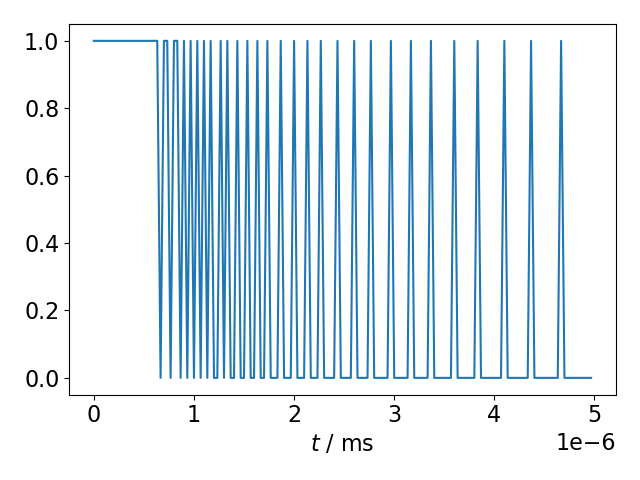

<IPython.core.display.Javascript object>


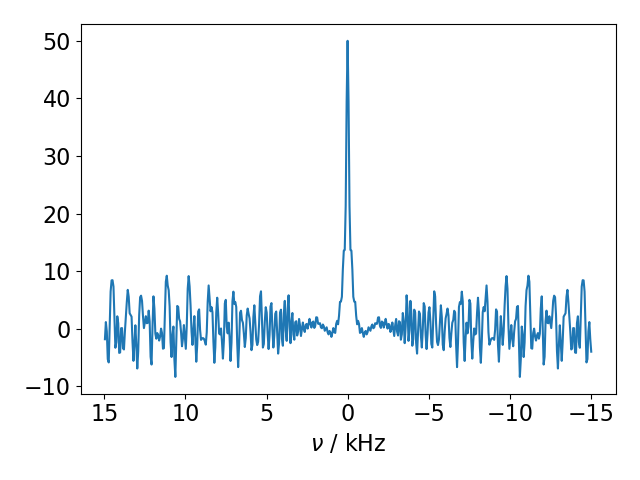

<AxesSubplot:xlabel='$\\nu$ / kHz'>

In [56]:
sc=Schedule(TD)
i=sc.log()
ist=IST(t,I,i)
ist.plot_schedule()
ist.plot_PSF()

# A step-by-step view
The following applies IST with 10 steps. Note that this will not yield the best performance, but allows us to view the procedure more clearly

<IPython.core.display.Javascript object>


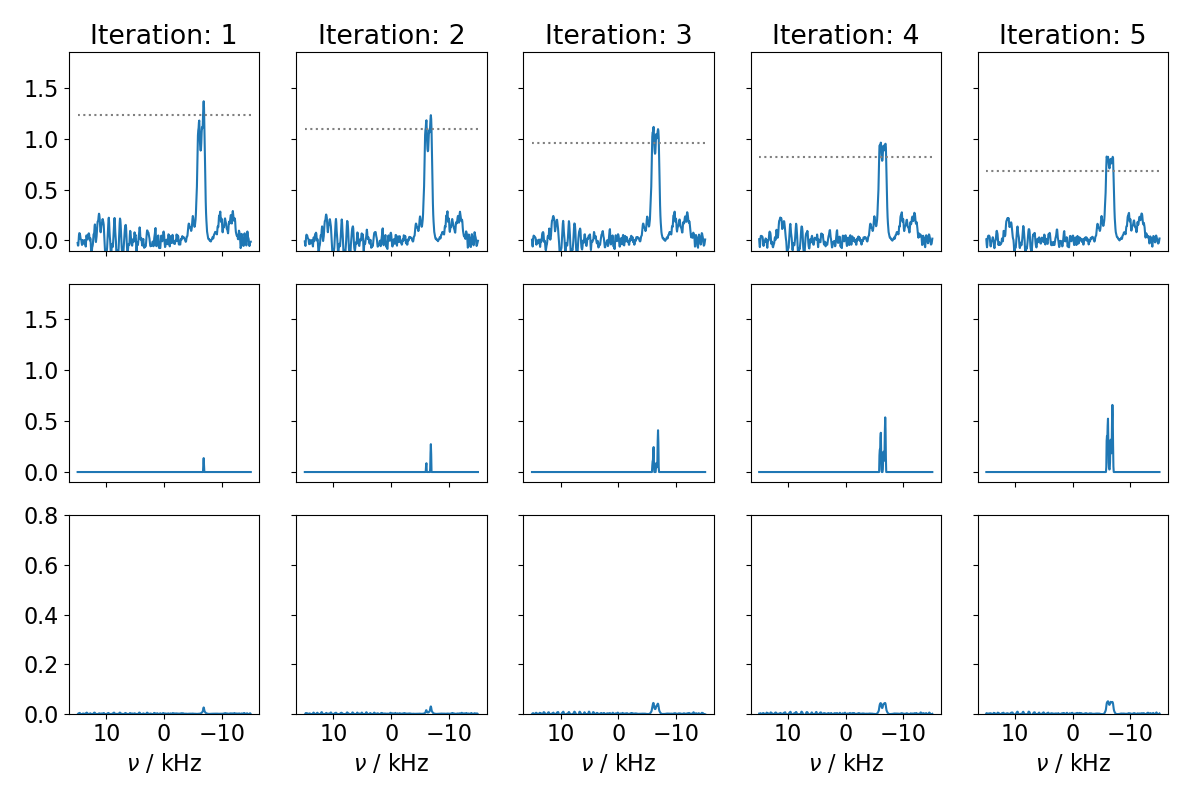

<IPython.core.display.Javascript object>


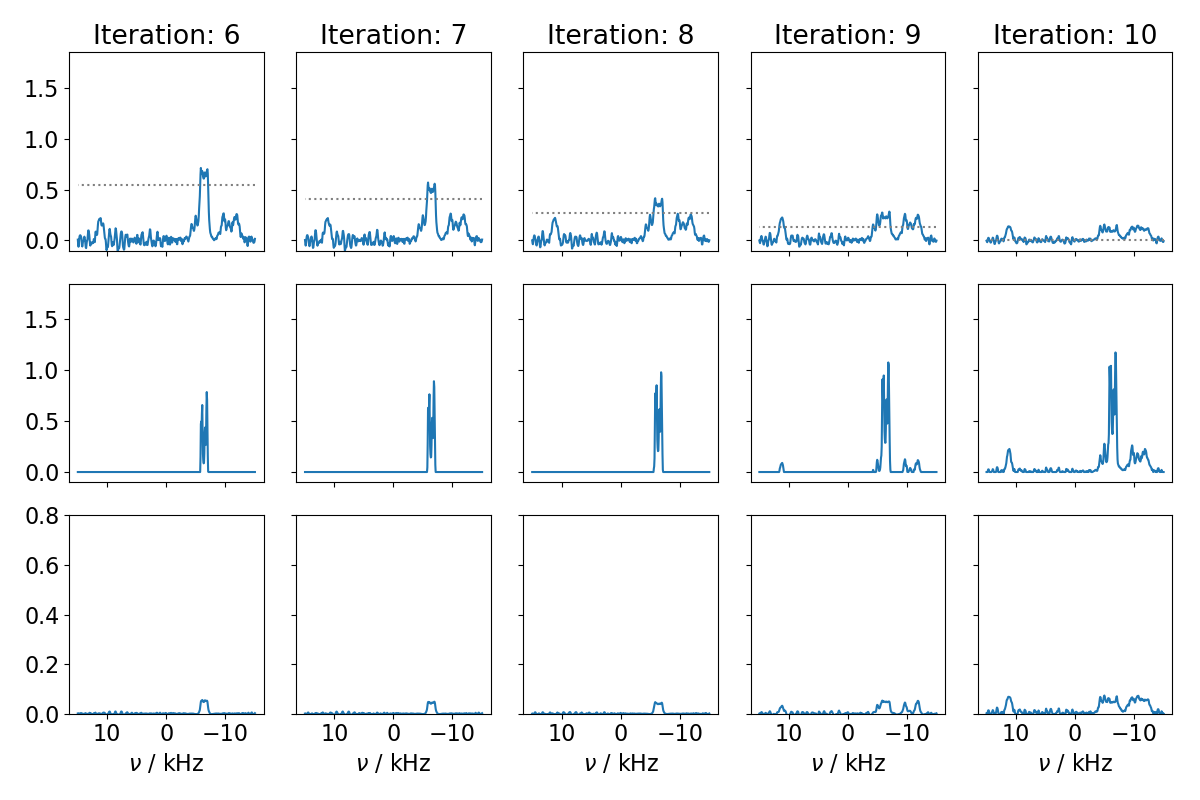

In [57]:
ist=IST(t,I/1e9,i,threshold=np.linspace(1,0,11))
fig,ax=plt.subplots(3,5)
fig1,ax1=plt.subplots(3,5)
for k,a in zip(range(1,11),np.concatenate((ax.T,ax1.T))):
    ist.plot_step(k,matchy=True,ax=a)
    for a0 in a:
        if not(a0.is_first_col()):
            a0.set_yticklabels('')
        if not(a0.is_last_row()):
            a0.set_xticklabels('')
            a0.set_xlabel('')
        if a0.is_first_row():
            a0.set_title(f'Iteration: {k}')
SZ=[12,8]
for a in np.concatenate((ax.T,ax1.T)):
    a[0].set_ylim([-.1,1.85])
    a[1].set_ylim([-.1,1.85])
    a[2].set_ylim([0,.8])

fig.set_size_inches(SZ)
fig.tight_layout()
fig1.set_size_inches(SZ)
fig1.tight_layout()

<IPython.core.display.Javascript object>


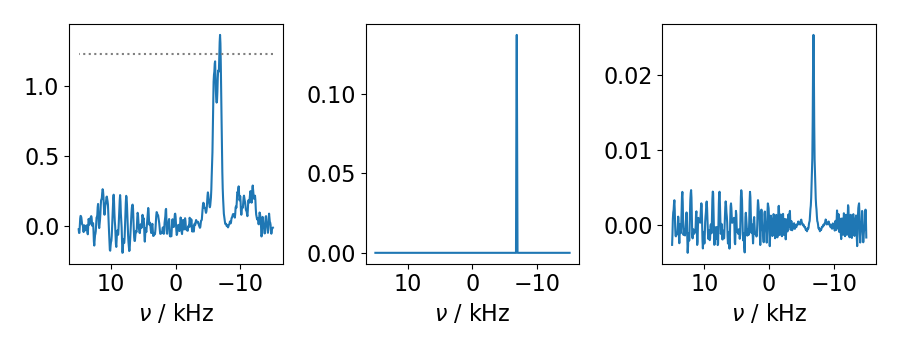

array([<AxesSubplot:xlabel='$\\nu$ / kHz'>,
       <AxesSubplot:xlabel='$\\nu$ / kHz'>,
       <AxesSubplot:xlabel='$\\nu$ / kHz'>], dtype=object)

In [58]:
ist.plot_step(1)

<IPython.core.display.Javascript object>


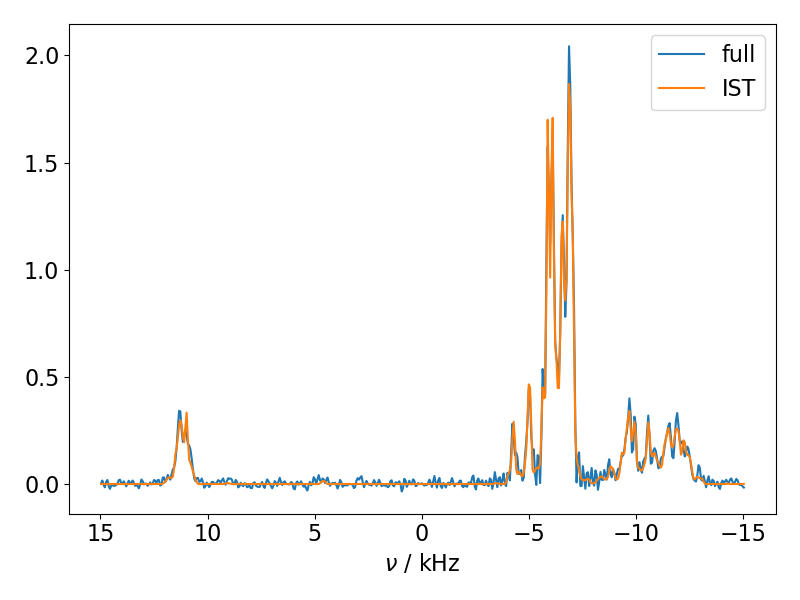

<AxesSubplot:xlabel='$\\nu$ / kHz'>

In [59]:
ist=IST(t,I/1e9,i)
fig,ax=plt.subplots()
fig.set_size_inches([8,6])
ist.plot_result(ax=ax)

<IPython.core.display.Javascript object>


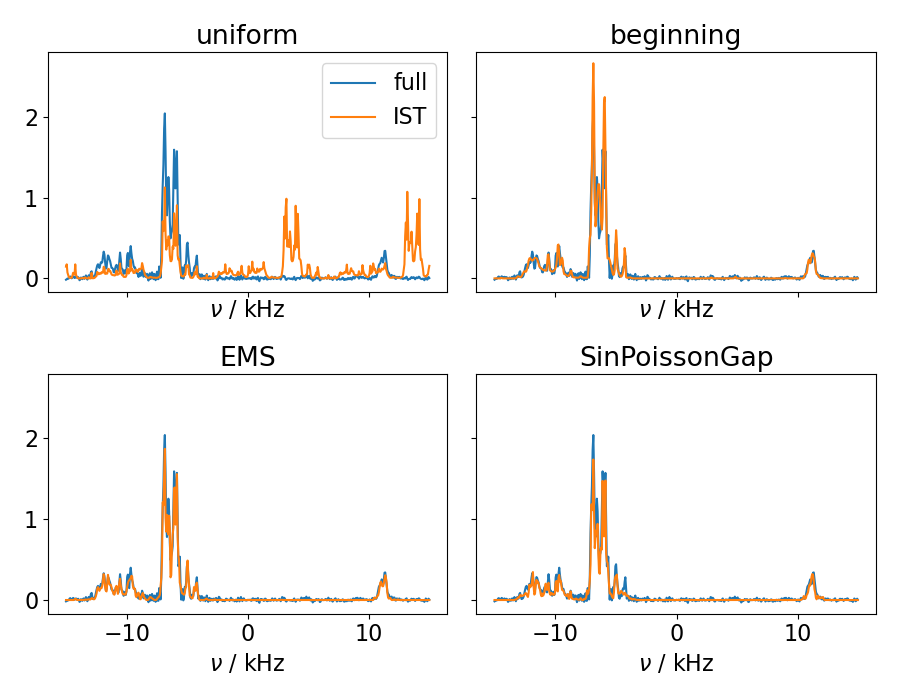

Sparsity: 0.3333333333333333
uniform: 5.222764208671132
Sparsity: 0.3333333333333333
beginning: 3.1280450530541186
Sparsity: 0.3333333333333333
EMS: 3.5450753071671346
Sparsity: 0.32666666666666666
SinPoissonGap: 3.8189033255483986


In [61]:
sc=Schedule(TD,sparsity=.33)
schedules=['uniform','beginning','EMS','SinPoissonGap']
fig,ax=plt.subplots(2,2,sharex=True,sharey=True)
ax=ax.flatten()
for a,schedule in zip(ax,schedules):
    i=getattr(sc,schedule)()
    ist=IST(t,I/1e9,i)
    ist.plot_result(ax=a)
    if not(a.is_first_col() and a.is_first_row()):
        a.get_legend().remove()
    a.set_title(schedule)
    error=np.sqrt(((ist.Sfull.real-ist.S[-1].real)**2).sum())
    print(f'{schedule}: {error}')
fig.set_size_inches([9,7])
fig.tight_layout()

<IPython.core.display.Javascript object>


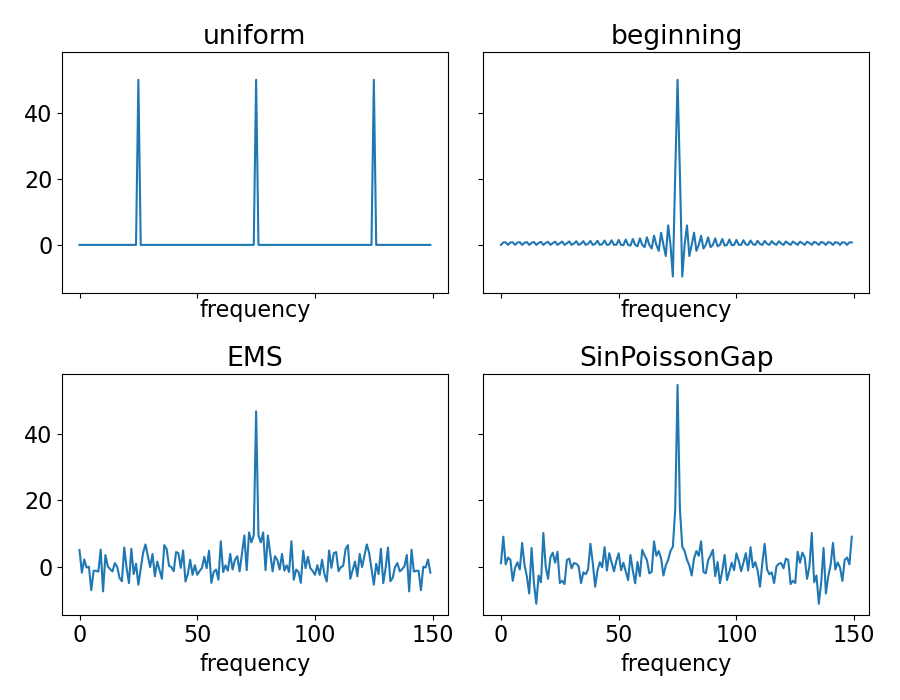

Sparsity: 0.3333333333333333
Sparsity: 0.3333333333333333
Sparsity: 0.31333333333333335
Sparsity: 0.36666666666666664


In [62]:
sc=Schedule(TD,sparsity=.33)
schedules=['uniform','beginning','EMS','SinPoissonGap']
fig,ax=plt.subplots(2,2,sharex=True,sharey=True)
ax=ax.flatten()
for schedule,a in zip(schedules,ax):
    getattr(sc,schedule)()
    sc.plot_PSF(ax=a)
    a.set_title(schedule)
fig.set_size_inches([9,7])
fig.tight_layout()

<IPython.core.display.Javascript object>


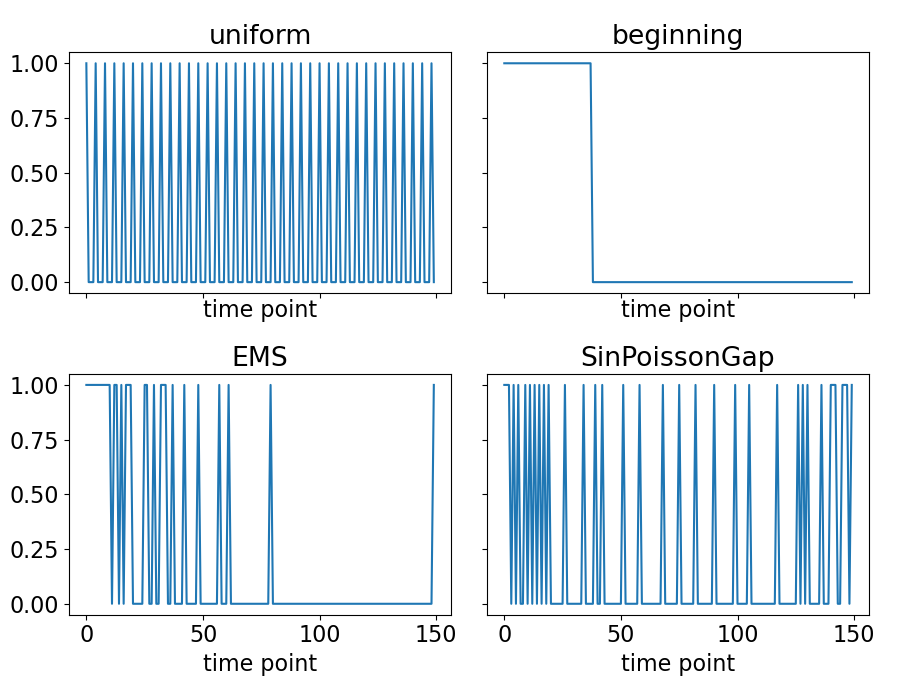

Sparsity: 0.25333333333333335
Sparsity: 0.25333333333333335
Sparsity: 0.2
Sparsity: 0.23333333333333334


In [63]:
sc=Schedule(TD,sparsity=.25)
schedules=['uniform','beginning','EMS','SinPoissonGap']
fig,ax=plt.subplots(2,2,sharex=True,sharey=True)
ax=ax.flatten()
for schedule,a in zip(schedules,ax):
    getattr(sc,schedule)()
    sc.plot_schedule(ax=a)
    a.set_title(schedule)
fig.set_size_inches([9,7])
fig.tight_layout()

# Maximum Entropy

In [157]:
from scipy.optimize import curve_fit,minimize
class MaxEnt():
    def __init__(self,t,I,i,SI:int=None):
        self.t=t
        self.I=I
        self.Ifit=None
        self.Sfit=None
        self.i=i
        self.SI=2**(int(np.log2(len(I)))+2) if SI is None else SI
        self.out=None
        self.f=1/(2*t[1])*np.linspace(-1,1,self.SI)
        self.f-=np.diff(self.f[:2])/2
        
    def Target(self,I0):
        I=self.calcI(I0)
        S=np.abs(fft(I)).real
#         S/=S.sum()
        return (S*np.log2(S)).sum()
    


    def calcI(self,I0):
        I=np.zeros(self.I.shape,dtype=self.I.dtype)
        I[self.i]=self.I[self.i]
        I[~self.i]=np.array(I0[:len(I0)//2],dtype=complex)+1j*np.array(I0[len(I0)//2:],dtype=complex)
        return I

    #     def fit(self):
#         f=lambda x,*I0:self.Target(I0)
#         xdata=np.argwhere(~self.i)[:,0]
#         ydata=np.zeros(self.SI)
#         p0=np.zeros((~self.i).sum()*2)
#         out=curve_fit(f,xdata,ydata,p0=p0)
#         return out
    
    def fit(self):
        if self.Sfit is None:
            self.out=minimize(self.Target,np.zeros((~self.i).sum()*2))
            self.calc_Ifit()
        return self.Sfit
    
    def calc_Ifit(self):
        self.Ifit=self.calcI(self.out['x'])
        I0=np.concatenate((self.Ifit[:1],self.Ifit[1:]))
        apod=np.cos(np.arange(I0.size)*np.pi)**2
        self.Sfit=fftshift(fft(I0*apod,self.SI))
        return self
        
    
    
    def plot_results(self,ax=None):
        self.fit()
        if ax is None:ax=plt.subplots()[1]
        fig=ax.figure
        
        ax.plot(self.f/1e3,self.Sfit.real)
        ax.set_xlabel(r'$\nu$ / kHz')
        fig.tight_layout()
        return ax
        
        


In [158]:
i=sc.log()
max_ent=MaxEnt(t,I/1e9,i,SI)

In [159]:
out=max_ent.fit()

<IPython.core.display.Javascript object>


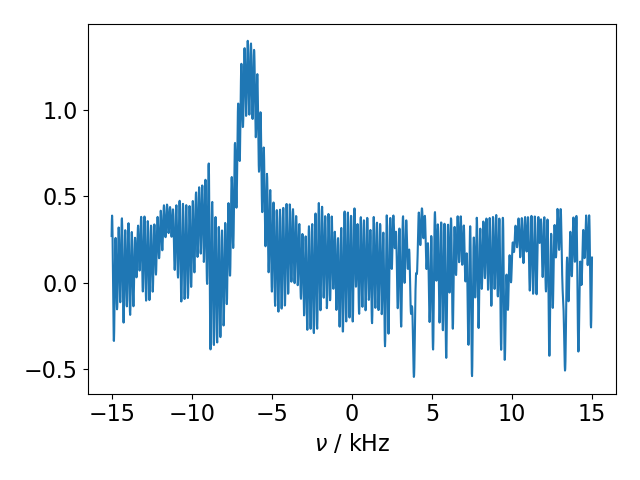

<AxesSubplot:xlabel='$\\nu$ / kHz'>

In [160]:
max_ent.plot_results()

<IPython.core.display.Javascript object>


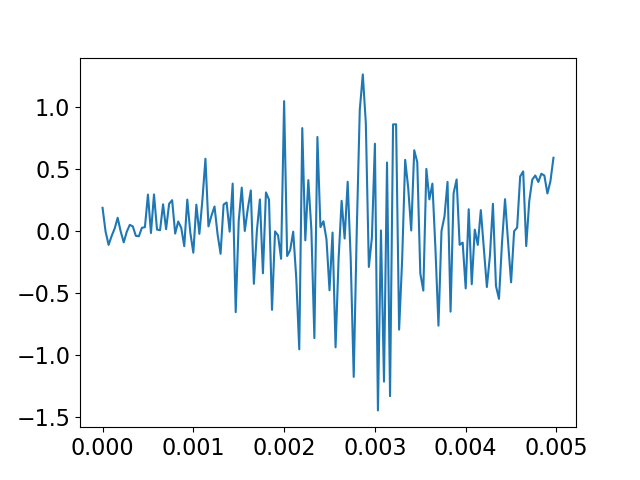

/Users/albertsmith/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [162]:
ax=plt.subplots()[1]
ax.plot(max_ent.t,max_ent.calcI(self.out['x']))